In [1]:
import numpy as np
import os
import scipy.io as scio
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
import matplotlib as mpl
from matplotlib import pyplot as plt
from tqdm import tqdm
from tqdm.auto import trange
from matplotlib import colors
import argparse
import sys
sys.path.append("/media/miplab-nas2/Data3/Danyang/Multi-Echo-BOLD_fingerprinting")
sys.path.append("E:\sp2\Multi-Echo-BOLD_fingerprinting")
from scipy.io import loadmat

from fingerprinting.load_data import load_data_split
from fingerprinting.pca_denoising import pca_denoising
from fingerprinting.draw_results import *
from fingerprinting.ICC import calculate_ICC
from fingerprinting.utils import *
from fingerprinting.utils_identifiability import *
from fingerprinting.utils_neuromaps_brain import *

d:\anaconda3\envs\fingerprint\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_path='./data0'
result_path='./fingerprinting/results_speedup_test'

echoes_total_num = 5  # including optimal combination
echo_optcomb = echoes_total_num - 1 # the last echo is the optcomb
subjects_total_num = int(len(os.listdir(data_path)) / (echoes_total_num)) # there is another optimal TS.
subjects_num = subjects_total_num
print("There are " + str(subjects_total_num) + " subjects with " + str(echoes_total_num) + " echoes (include 1 optcomb).")

# Load data
TCs_test, TCs_retest, FCs_test, FCs_retest, orig_matrixs_test, orig_matrixs_retest = load_data_split(data_path, subjects_num, echoes_total_num)
TCs = np.concatenate((TCs_test, TCs_retest), axis=3)
TCs = TCs[:,3]

There are 84 subjects with 5 echoes (include 1 optcomb).


In [37]:
FCs = []
for echo in range(5):
    FCs.append(np.corrcoef(TCs[echo])) 
FCs = np.array(FCs)
FCs = FCs[:,:200,:200]

In [38]:
# for echo_test in tqdm(range(echoes_total_num), desc='echo1', leave=False): # Another echo_index: for optimal combination.
#     for echo_retest in tqdm(range(echoes_total_num), desc='echo2', leave=False):
ICC_matrices = []
ICC_matrices_opt = []
for echo_test in tqdm(range(echoes_total_num), desc='echo1', leave=False):
    echo_retest = echo_test
    FC_list_test = orig_matrixs_test[echo_test].T
    FC_list_retest = orig_matrixs_retest[echo_retest].T
    FCs = np.stack((FC_list_test,FC_list_retest), axis=1)
    ICC_matrix = compute_ICC_idenfiability_from_single_FCs(FCs)
    ICC_matrices.append(ICC_matrix)

    list_Idiff = compute_Idiff_PCA_two_datasets_from_FCs(FC_list_test, FC_list_retest)
    Idiff_opt = np.max(list_Idiff[:,1])
    m_star = int(list_Idiff[np.where(list_Idiff[:,1] == Idiff_opt)[0][0], 0])
    FC_list_test_opt, FC_list_retest_opt = compute_FCs_PCA_opt_two_datasets_from_FCs(FC_list_test,FC_list_retest,m_star)

    FCs_opt = np.stack((FC_list_test_opt,FC_list_retest_opt), axis=1)
    ICC_matrix_opt = compute_ICC_idenfiability_from_single_FCs(FCs_opt)
    ICC_matrices_opt.append(ICC_matrix_opt)
ICC_matrices = np.array(ICC_matrices)
ICC_matrices_opt = np.array(ICC_matrices_opt)


In [31]:
try:
    yeoOrder,limit_yeo=load_yeonets_matfile(filename="/media/miplab-nas2/Data3/Danyang/Multi-Echo-BOLD_fingerprinting/yeo_RS7_Schafer200S.mat")
except FileNotFoundError:
    yeoOrder,limit_yeo=load_yeonets_matfile(filename="E:\sp2\Multi-Echo-BOLD_fingerprinting\yeo_RS7_Schafer200S.mat")


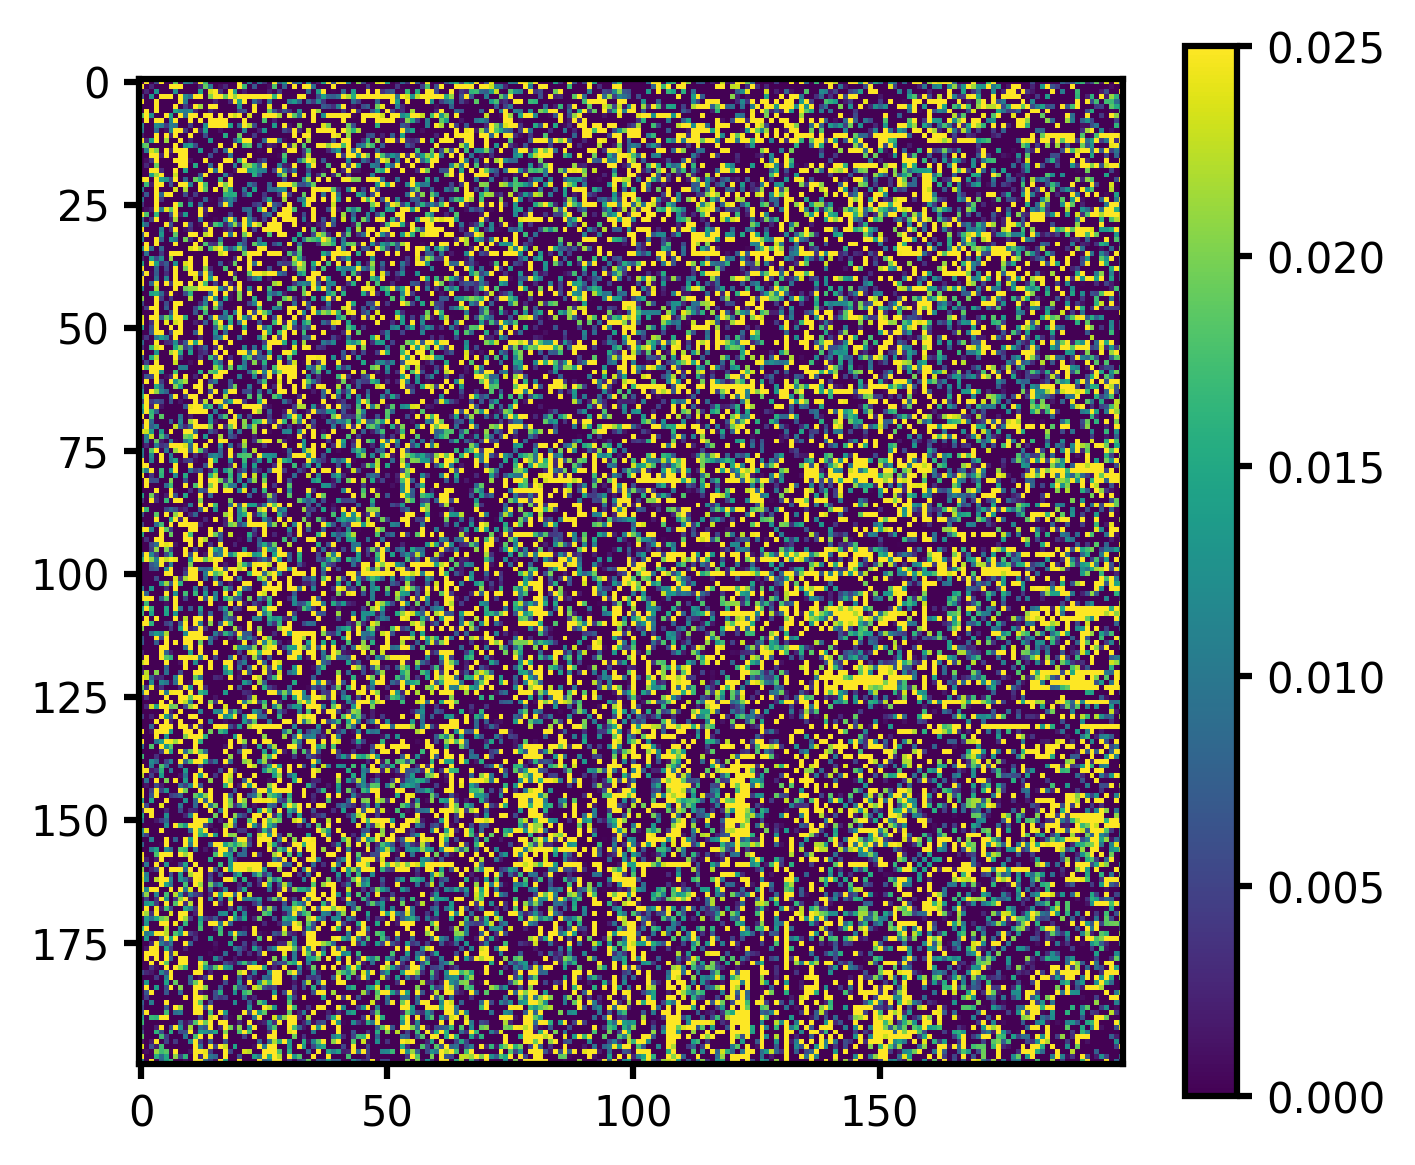

In [52]:
fig = plt.figure(dpi=300,figsize=(18,10))
ax1 = plt.subplot(231)
plt.imshow(ICC_matrices[4][:200,:200][yeoOrder,:][:,yeoOrder] - ICC_matrices[1][:200,:200][yeoOrder,:][:,yeoOrder], vmin=0, vmax=0.025)
plt.colorbar()


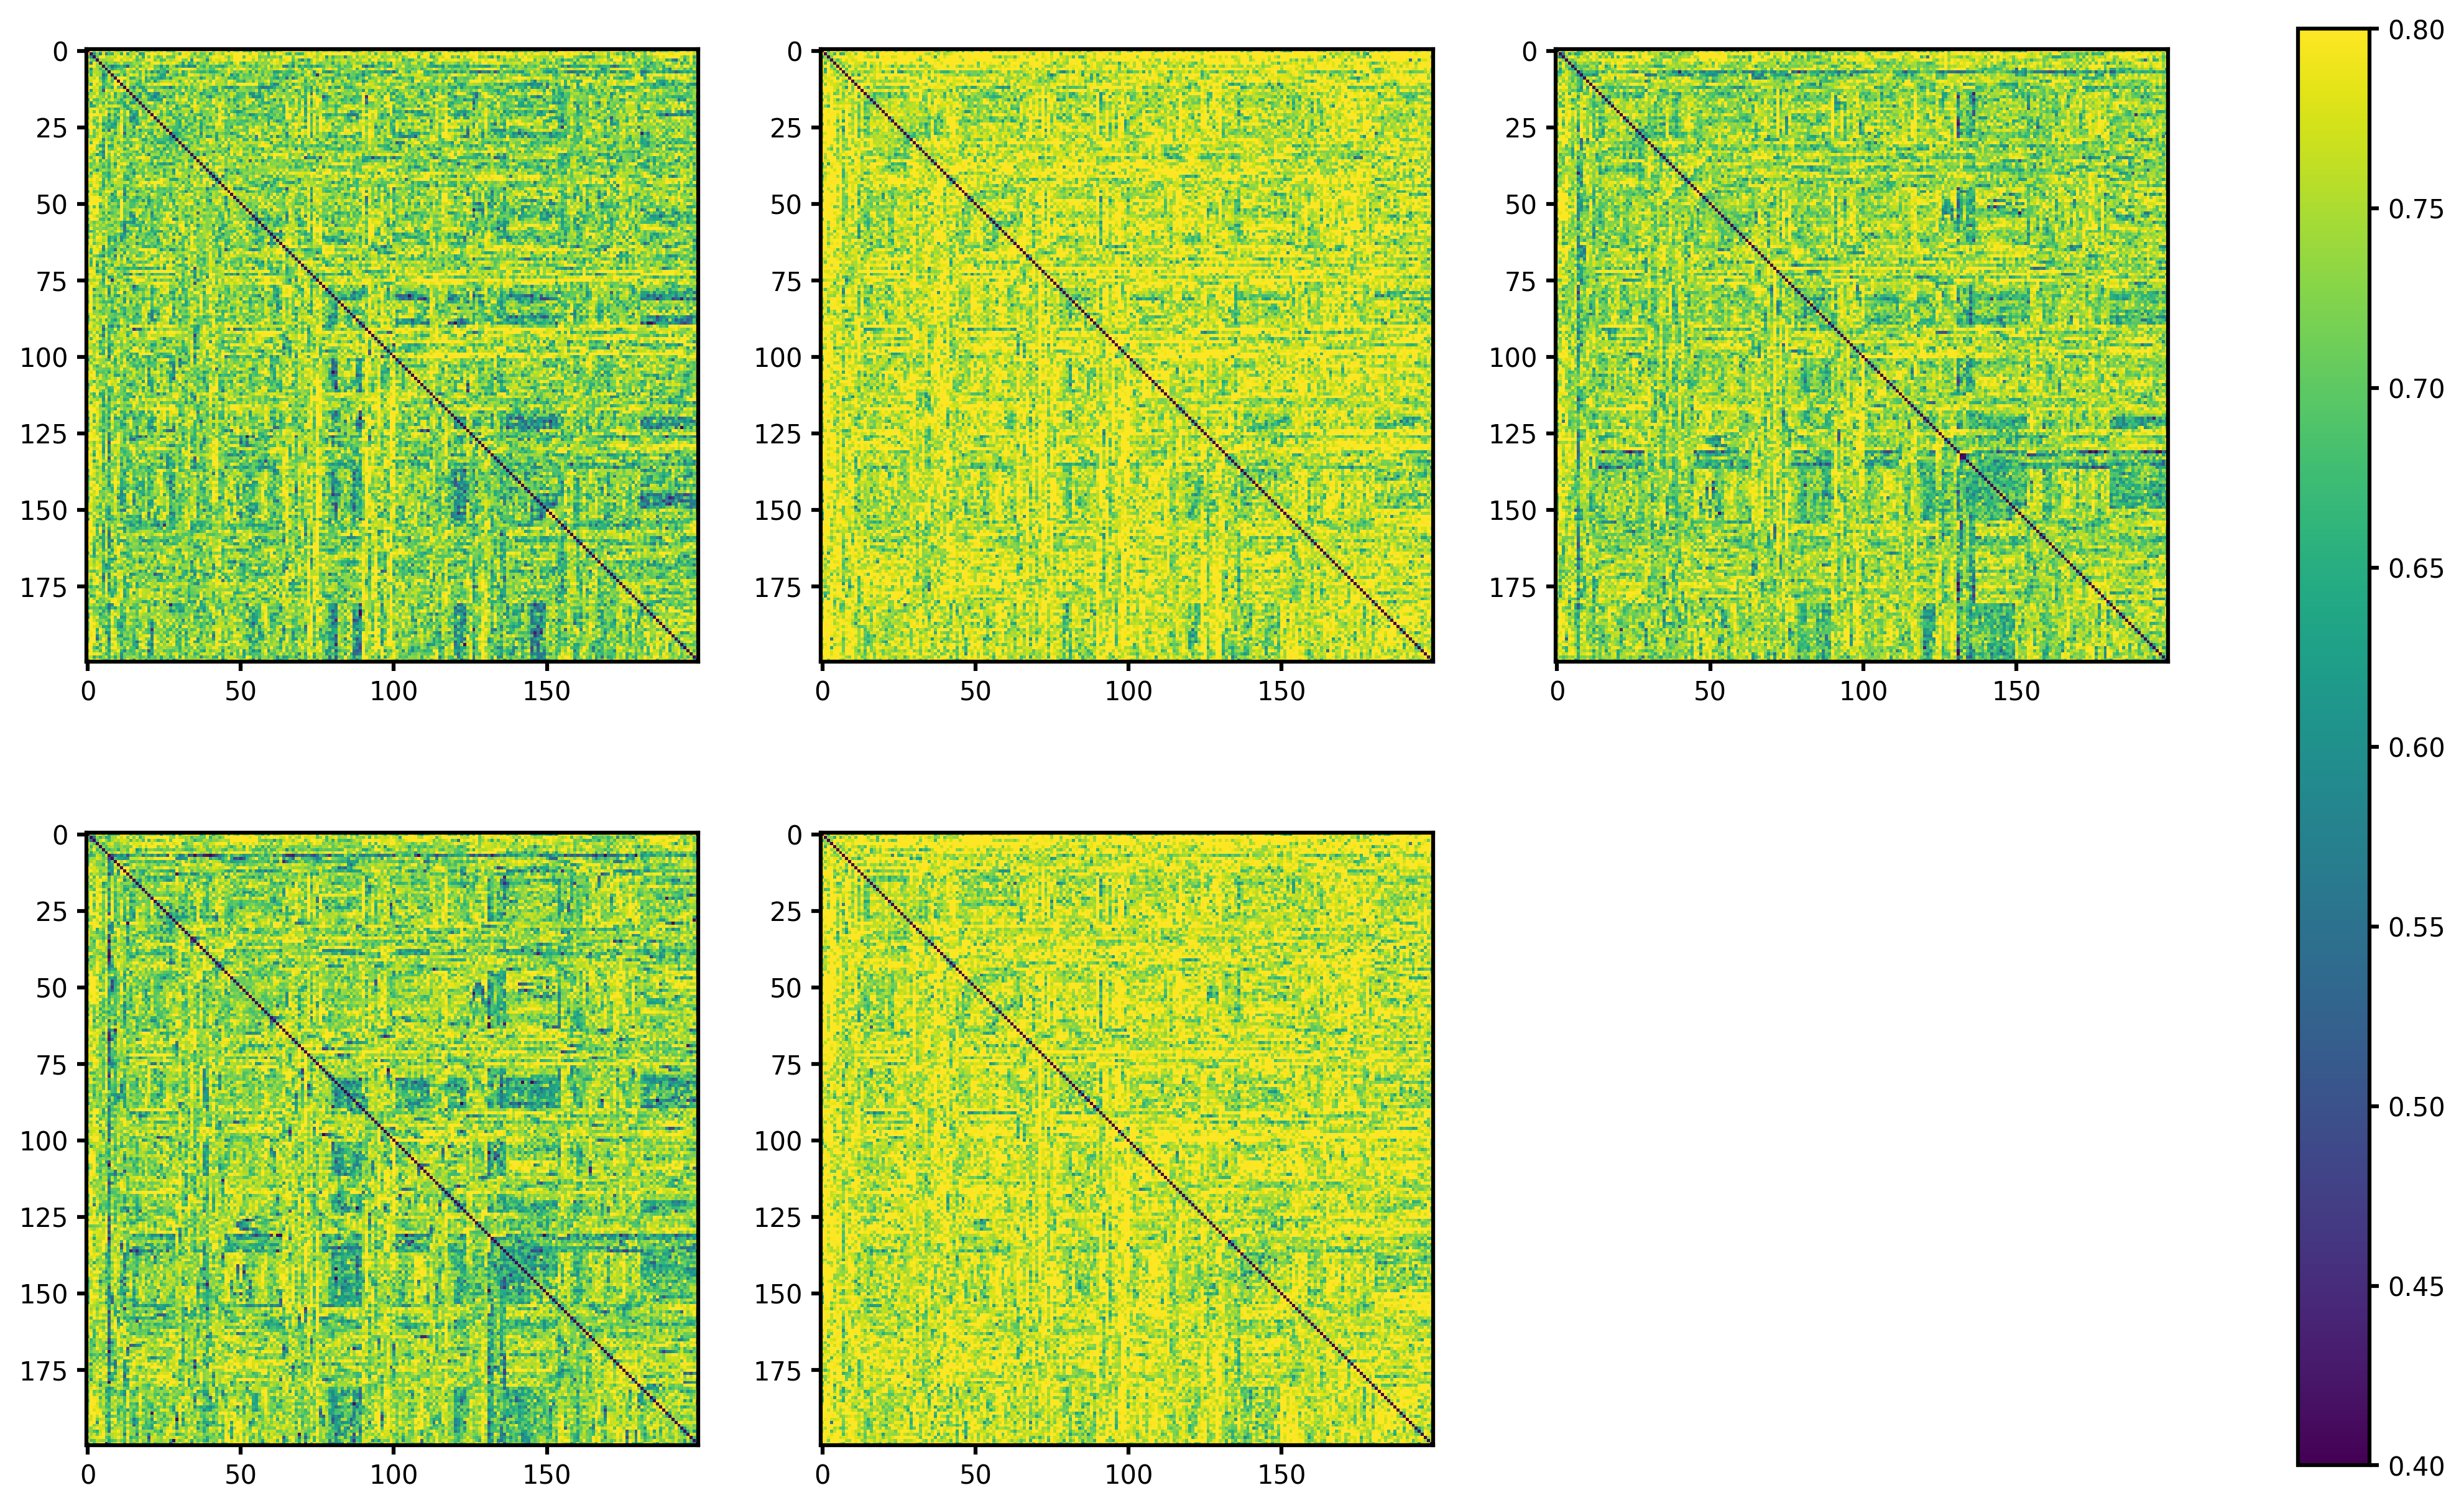

In [45]:
fig = plt.figure(dpi=300,figsize=(18,10))
ax1 = plt.subplot(231)
plt.imshow(ICC_matrices[0][:200,:200][yeoOrder,:][:,yeoOrder], vmin=0.4, vmax=0.8)

ax2 = plt.subplot(232)
plt.imshow(ICC_matrices[1][:200,:200][yeoOrder,:][:,yeoOrder], vmin=0.4, vmax=0.8)

ax3 = plt.subplot(233)
plt.imshow(ICC_matrices[2][:200,:200][yeoOrder,:][:,yeoOrder], vmin=0.4, vmax=0.8)

ax4 = plt.subplot(234)
plt.imshow(ICC_matrices[3][:200,:200][yeoOrder,:][:,yeoOrder], vmin=0.4, vmax=0.8)

ax5 = plt.subplot(235)
plt.imshow(ICC_matrices[4][:200,:200][yeoOrder,:][:,yeoOrder], vmin=0.4, vmax=0.8)

plt.colorbar(ax=[ax1,ax2,ax3,ax4,ax5])

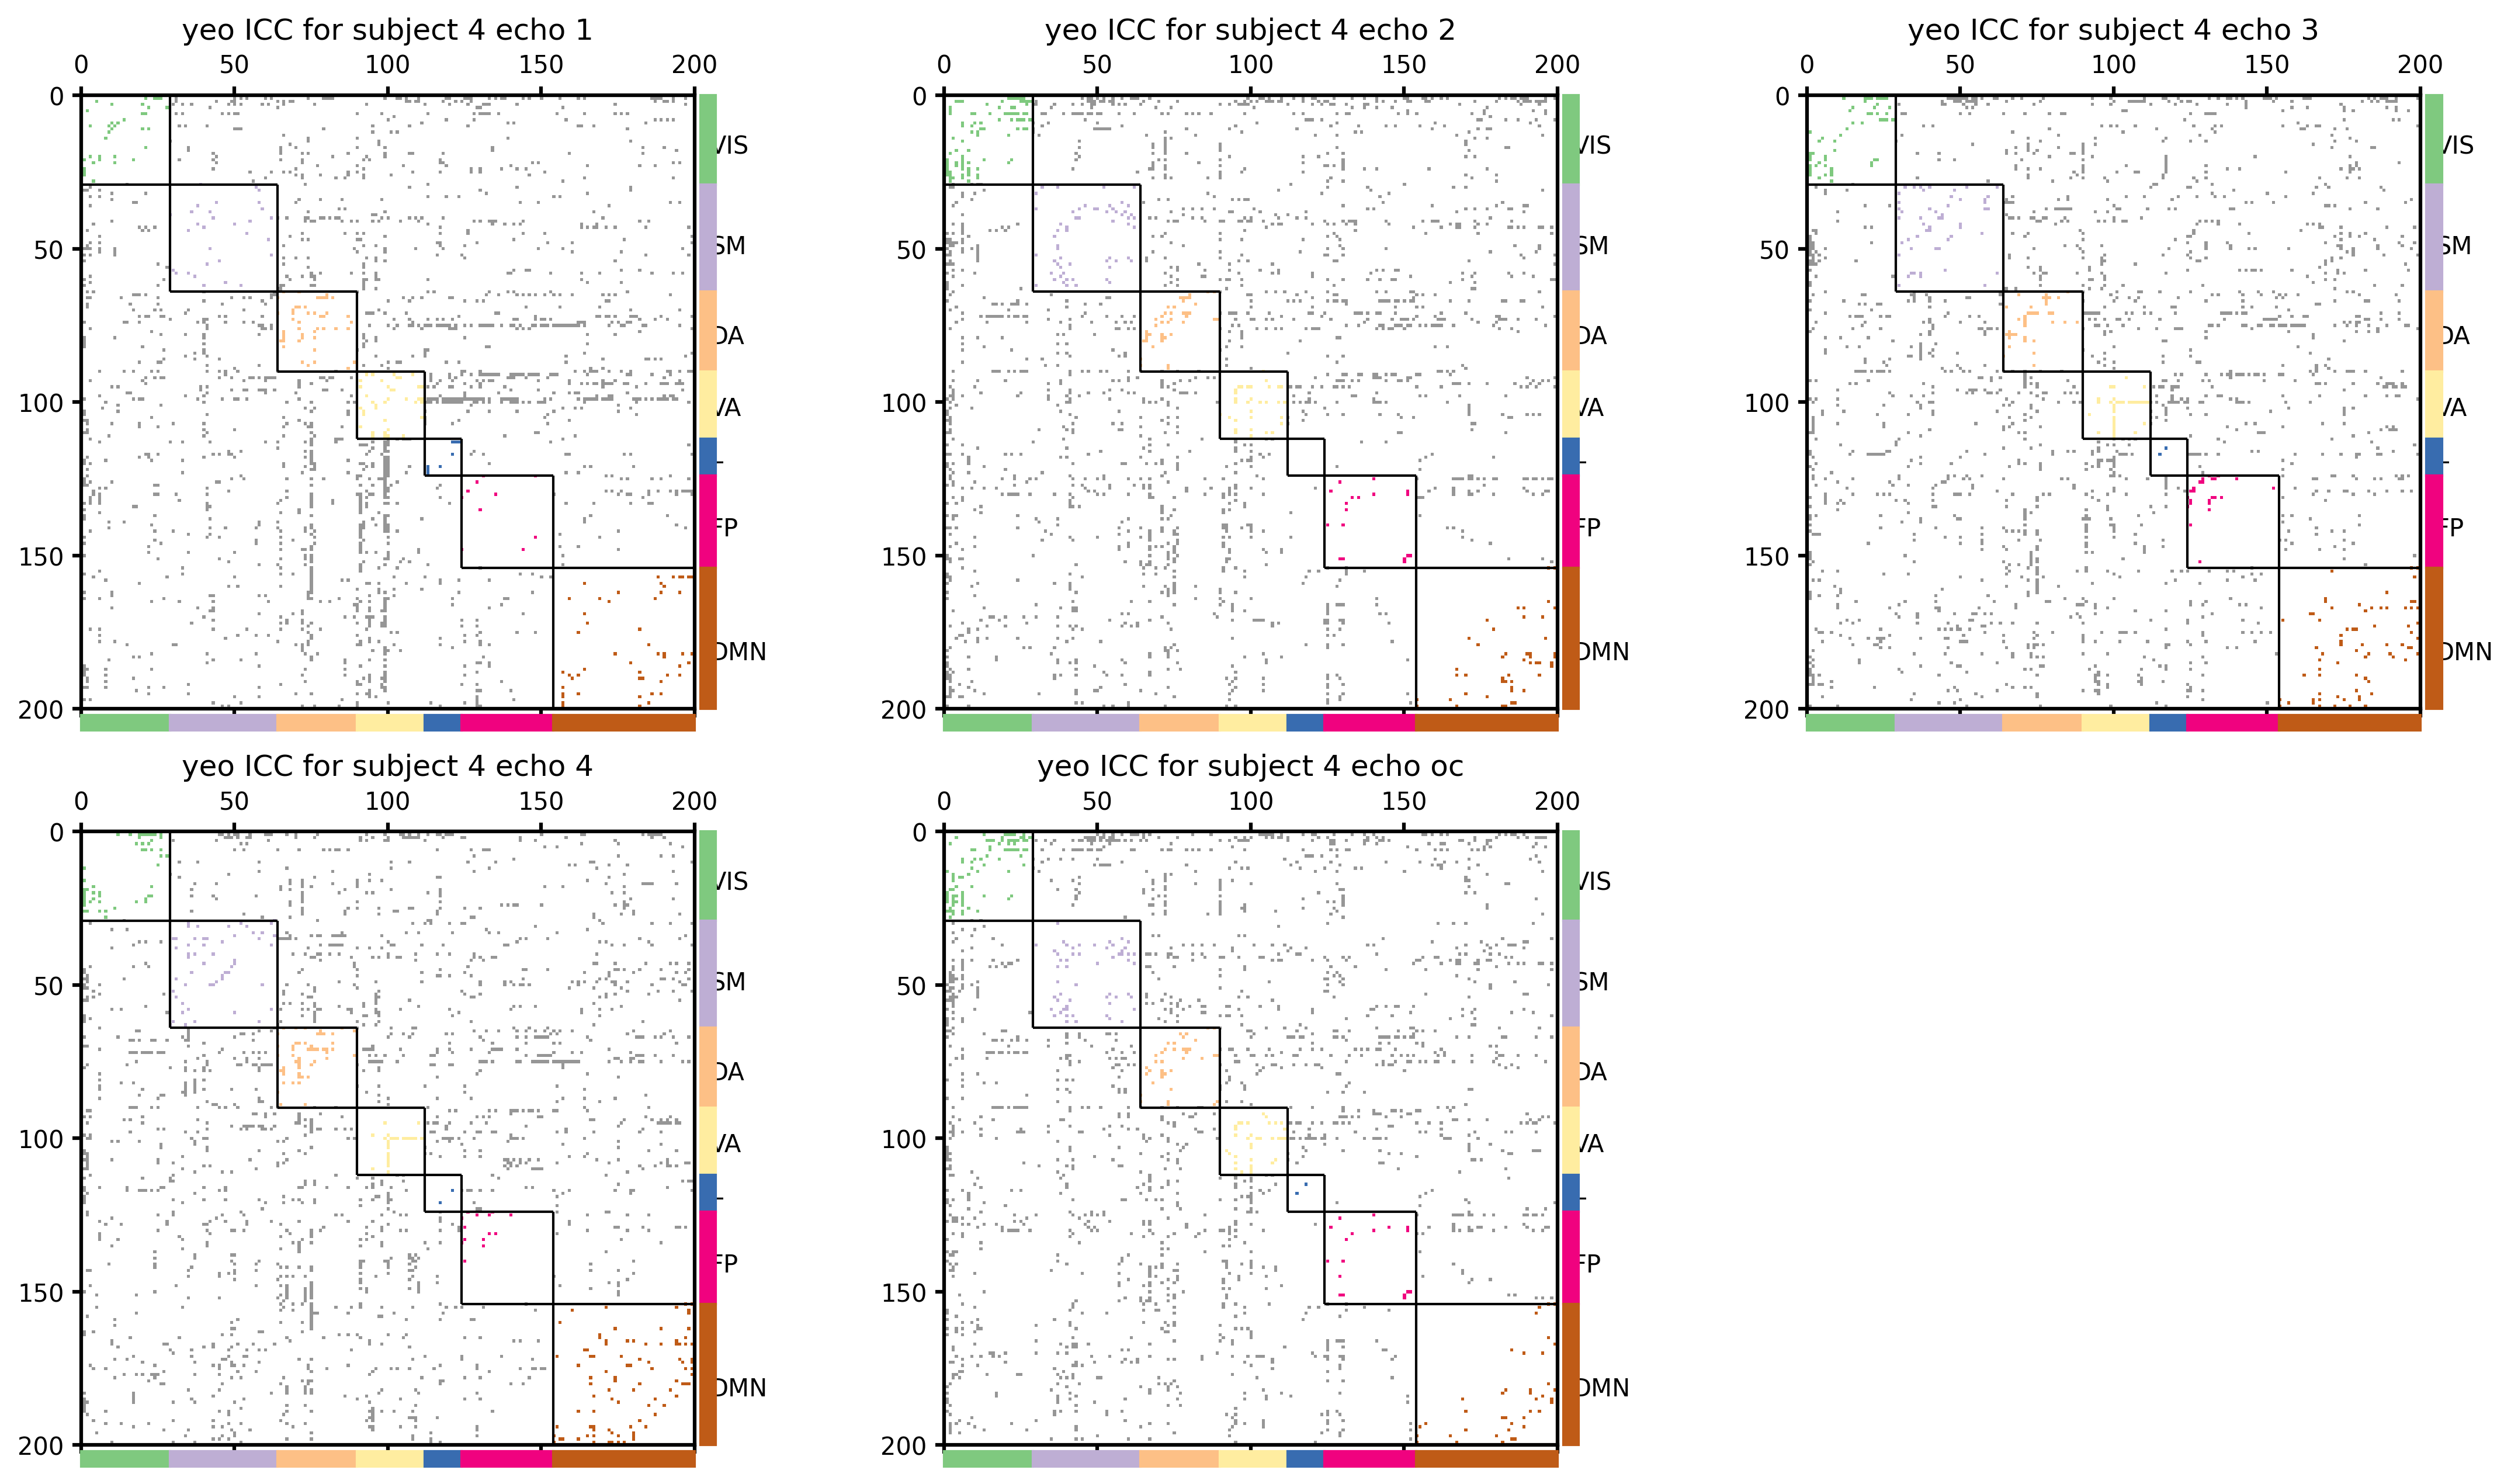

In [34]:
fig = plt.figure(dpi=300,figsize=(18,10))
ax1 = plt.subplot(231)
plot_ICC_mat(ICC_matrices[0][:200,:200],yeo_net=True, yeoOrder=yeoOrder, limit_yeo=limit_yeo, ax=ax1, title="yeo ICC for subject 4 echo 1")

ax2 = plt.subplot(232)
plot_ICC_mat(ICC_matrices[1][:200,:200],yeo_net=True, yeoOrder=yeoOrder, limit_yeo=limit_yeo, ax=ax2, title="yeo ICC for subject 4 echo 2")

ax3 = plt.subplot(233)
plot_ICC_mat(ICC_matrices[2][:200,:200],yeo_net=True, yeoOrder=yeoOrder, limit_yeo=limit_yeo, ax=ax3, title="yeo ICC for subject 4 echo 3")

ax4 = plt.subplot(234)
plot_ICC_mat(ICC_matrices[3][:200,:200],yeo_net=True, yeoOrder=yeoOrder, limit_yeo=limit_yeo, ax=ax4, title="yeo ICC for subject 4 echo 4")

ax5 = plt.subplot(235)
plot_ICC_mat(ICC_matrices[4][:200,:200],yeo_net=True, yeoOrder=yeoOrder, limit_yeo=limit_yeo, ax=ax5, title="yeo ICC for subject 4 echo oc")


findfont: Font family ['PT Serif Caption'] not found. Falling back to DejaVu Sans.


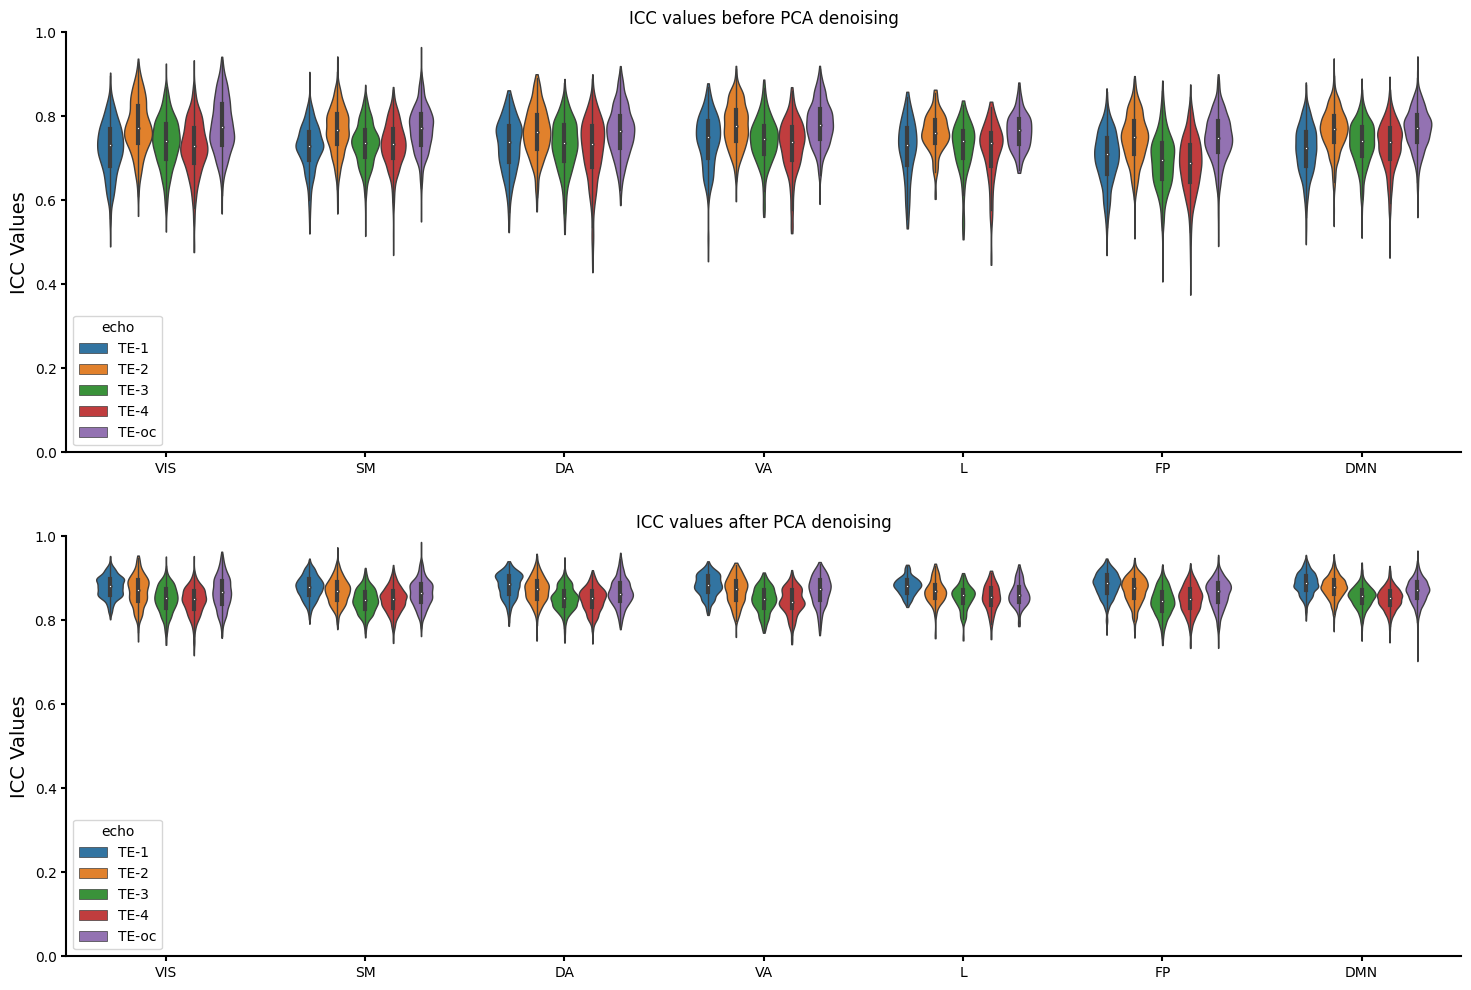

In [32]:

fig = plt.figure(dpi=100, figsize=(18,12))
ax1 = plt.subplot(211)
plot_ICCs_violins(ICC_matrices, yeoOrder=yeoOrder,limit_yeo=limit_yeo, ax=ax1, title="ICC values before PCA denoising")

ax2 = plt.subplot(212)
plot_ICCs_violins(ICC_matrices_opt, yeoOrder=yeoOrder,limit_yeo=limit_yeo, ax=ax2, title="ICC values after PCA denoising")
     

In [7]:
N=200
yeo_all=loadmat('E:\sp2\Multi-Echo-BOLD_fingerprinting\yeo_RS7_Schafer{0}S.mat'.format(N))
nodeID_yeomap=np.array([i[0] for i in yeo_all['yeoROIs']])

node_strength=np.zeros(N)
for i in range(1,8):
    node_strength[np.array(nodeID_yeomap==i)[:N]]=(i)*10+np.random.normal(loc=0.0,scale=0.1,size=sum(np.array(nodeID_yeomap==i)[:N]))

cmap = plt.get_cmap('tab20')
new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=0, b=1),
        cmap(np.linspace(0, 0.35, 1000)))


In [23]:
ICC_vectors = np.sum(ICC_matrices, axis=1)[:,:200]
ICC_vectors_opt = np.sum(ICC_matrices_opt, axis=1)[:,:200]
print(ICC_vectors[0].min())
print(ICC_vectors[0].max())

146.88273789828096
169.42892213910667


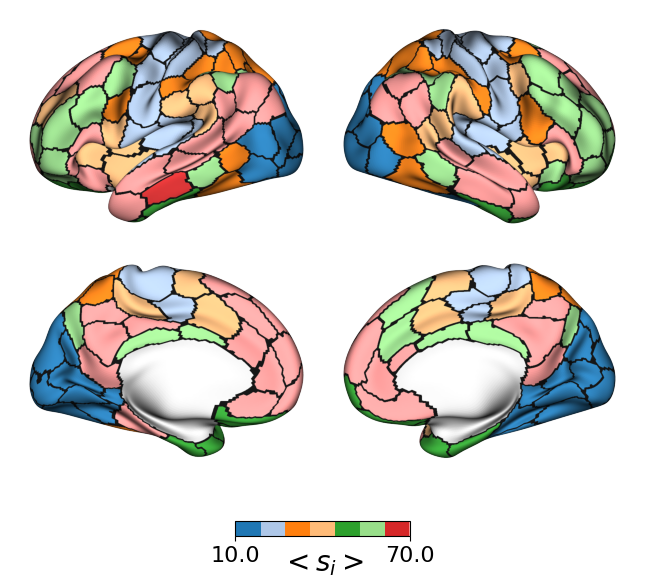

In [9]:
fig=normal_view(node_strength,edges=True,exp_form=False,q_thresh=15,cmap='custom', arcellation=N,brightness=0.8,vmin=10,vmax=70)
fig


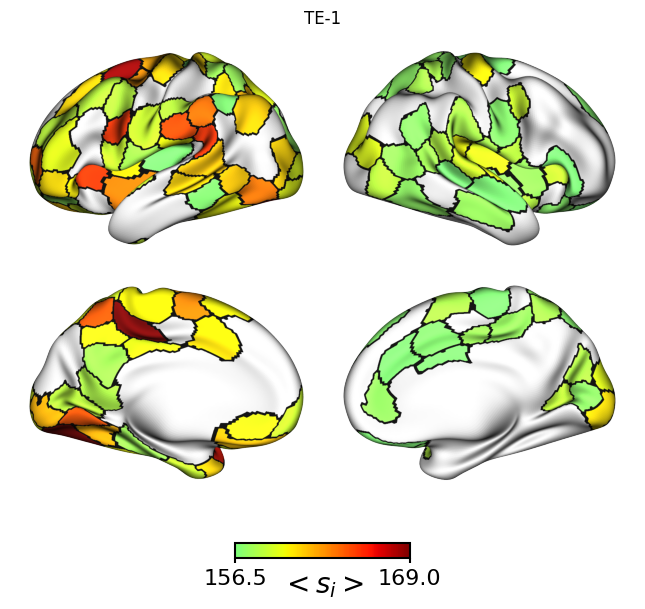

In [62]:
fig=normal_view(ICC_vectors[0],edges=True,exp_form=False,q_thresh=0,cmap='custom',parcellation=N,brightness=0.8, title="TE-1", vmin=157, vmax=169)
fig


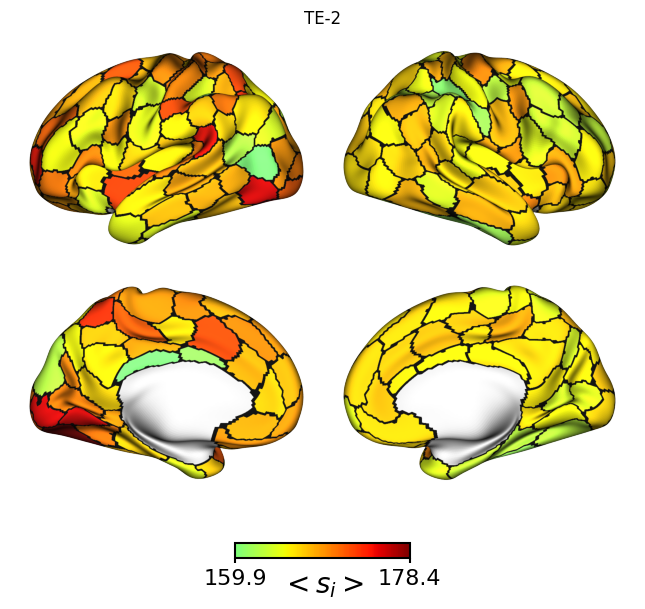

In [25]:

fig=normal_view(ICC_vectors[1],edges=True,exp_form=False,q_thresh=0,cmap='custom',parcellation=N,brightness=0.8,vmin=ICC_vectors[1].min(),vmax=ICC_vectors[1].max(), title="TE-2")
fig


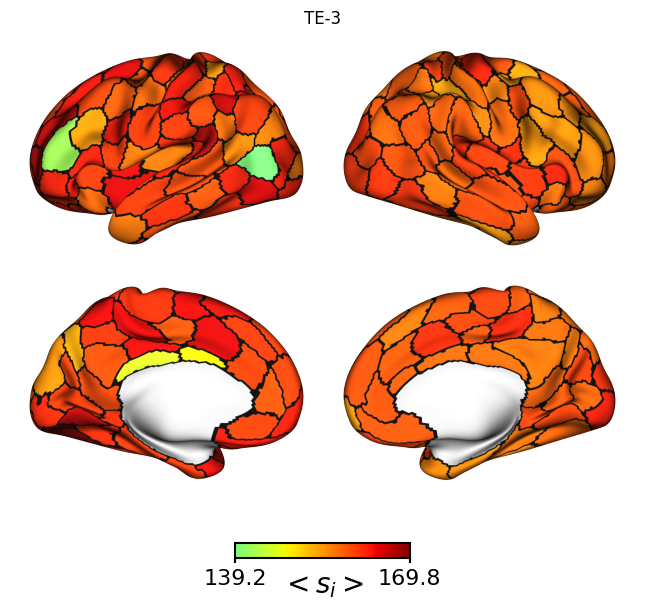

In [26]:
fig=normal_view(ICC_vectors[2],edges=True,exp_form=False,q_thresh=0,cmap='custom',parcellation=N,brightness=0.8,vmin=ICC_vectors[2].min(),vmax=ICC_vectors[2].max(), title="TE-3")
fig


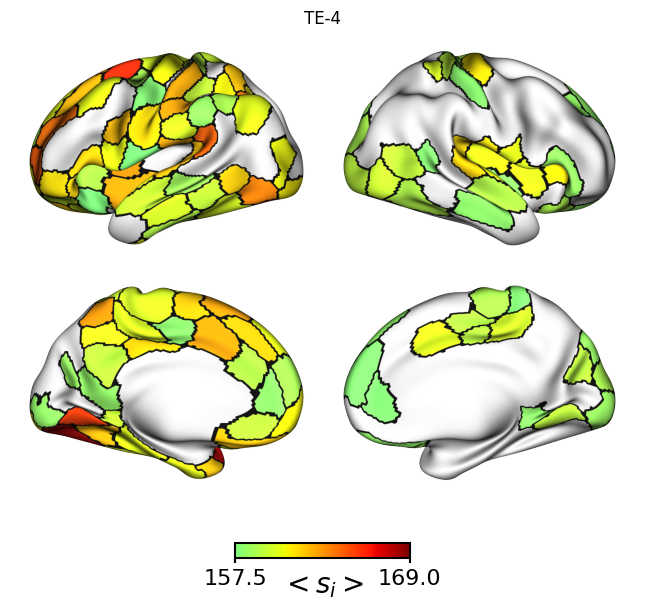

In [61]:
fig=normal_view(ICC_vectors[3],edges=True,exp_form=False,q_thresh=0.4,cmap='custom',parcellation=N,brightness=0.8, title="TE-4",vmin=157,vmax=169)
fig


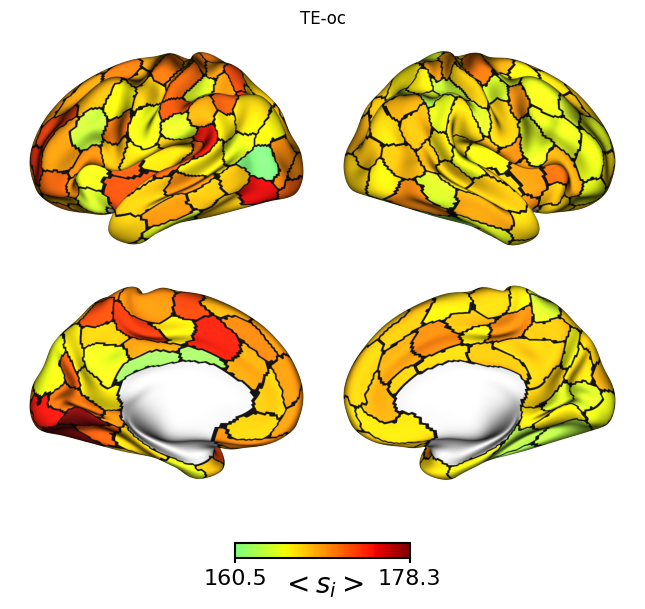

In [28]:
fig=normal_view(ICC_vectors[4],edges=True,exp_form=False,q_thresh=0,cmap='custom',parcellation=N,brightness=0.8,vmin=ICC_vectors[4].min(),vmax=ICC_vectors[4].max(), title="TE-oc")
fig
